In [103]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse 
import networkx as nx

# Earthquake metric functions 

In [104]:
def mcvalue(m, mbin):
    density = np.histogram(m, range = (min(m) - 1, max(m) + 1), density=True)
    return density[1][np.argmax(density[0])]

In [105]:
def haversine(lat1, lon1, lat2, lon2):
    """
    To calculate the L2 distance on the sphere
    """
    rad=np.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(np.sin(rad*dlat/2))**2 + np.cos(rad*lat1)*np.cos(rad*lat2)*(np.sin(rad*dlon/2))**2
    distancia=2*R*np.arcsin(np.sqrt(a))
    return distancia

In [106]:
def dist_quakes(catalogo, B, c, d):
    """
    Returns matrix with the distances between earthquakes. If the value is negative
    then earthquake i happened after earthquake j.
    The geographical distance used is the product metric (haversine^2 + L2^2)^1/2 (which
    won't be truthful for long distances)
    """
    distancias = np.zeros(shape=(catalogo.shape[0], catalogo.shape[0]))
    for i in range(catalogo.shape[0]):
        for j in range(i+1, catalogo.shape[0]):
            sismo_i = catalogo.iloc[i,:]
            sismo_j = catalogo.iloc[j,:]
            
            tau = sismo_j["timestamp"] - sismo_i["timestamp"]
            tau = tau.total_seconds() # The time scale will be in seconds
            
            r = np.sqrt(haversine(sismo_i["Longitud"], sismo_j['Longitud'],
                        sismo_i['Latitud'], sismo_j['Latitud'])**2 + 
                        (sismo_j['Profundidad']-sismo_i['Profundidad'])**2 )
            delta_m = sismo_j["Magnitud"] - sismo_i["Magnitud"]
            
            distancias[i,j] = c*tau* (r**d) *(10**(-B * delta_m))
             
    return distancias           

In [107]:
def dist_quakes_sparse(catalogo, B, c, d, max_cluster=1000):
    """
    Returns matrix with the distances between earthquakes and the previous max_cluster earthquakes.
    The geographical distance used is the product metric (haversine^2 + L2^2)^1/2 (which
    won't be truthful for long distances)
    """
    lat=catalogo['Latitud'].to_numpy()
    long=catalogo['Longitud'].to_numpy()
    mag=catalogo["Magnitud"].to_numpy()
    time=((catalogo["timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).to_numpy()
    time=time/(60*60*24*365.2425)
    depth=catalogo['Profundidad'].to_numpy()
    distancias = np.zeros(shape=(catalogo.shape[0], max_cluster))
    space_matrix=np.zeros(shape=(catalogo.shape[0], max_cluster))
    time_matrix =np.zeros(shape=(catalogo.shape[0], max_cluster))
    for i in range(max_cluster):
        
        lat_shift= np.concatenate([np.zeros(i+1),lat[:-(i+1)]])
        long_shift=np.concatenate([ np.zeros(i+1),long[:-(i+1)]])
        mag_shift=np.concatenate([ np.zeros(i+1),mag[:-(i+1)]])
        time_shift=np.concatenate([np.zeros(i+1),time[:-(i+1)]])
        depth_shift=np.concatenate([ np.zeros(i+1),depth[:-(i+1)]])

            
        tau = time-time_shift
        r = np.sqrt(haversine(long, long_shift,
                        lat, lat_shift)**2 + 
                        (depth-depth_shift)**2 )

        delta_m = mag_shift -np.repeat(3,catalogo.shape[0] )
            
        distancias[:,i] = c*tau* (r**d) *(10**(-B * delta_m))
        distancias[:i,i]=np.infty 
        time_matrix[:,i]=tau
        space_matrix[:,i]=r
        
        #print('finished shift =  ', str(i))
    return distancias, space_matrix, time_matrix      

# Loading the data and normalising the time fields 

In [108]:
sismos = pd.read_csv(".//SSNMX_catalogo_20170901_20210510_lat12d85_18d66_lon-97d26_-88d69.csv",  skiprows=4)
sismos= sismos.dropna()
sismos

Fecha      Hora  Magnitud  Latitud  Longitud  Profundidad  \
0      2017-09-01  01:26:16       3.4  15.9832  -96.9505         25.8   
1      2017-09-01  01:29:47       3.5  16.6938  -95.1257         94.8   
2      2017-09-01  02:10:55       3.8  15.5425  -92.4787        187.6   
3      2017-09-01  02:15:28       3.5  16.0508  -97.1588         26.3   
4      2017-09-01  02:24:18       3.6  17.1730  -94.9790        121.0   
...           ...       ...       ...      ...       ...          ...   
54557  2021-05-10  02:10:19       3.8  15.9500  -95.6600         54.0   
54558  2021-05-10  02:15:51       3.9  17.4100  -94.8400        144.0   
54559  2021-05-10  03:35:19       3.9  14.9200  -94.0200         14.0   
54560  2021-05-10  05:13:42       4.5  14.0000  -92.1500         43.0   
54561  2021-05-10  08:41:23       4.0  16.5000  -95.3100         86.0   

                       Referencia de localizacion   Fecha UTC  Hora UTC  \
0       18 km al NORESTE de PUERTO ESCONDIDO, OAX  2017-09-01  06:26:16   
1               15 km al NORTE de CD IXTEPEC, OAX  2017-09-01  06:29:47   
2           32 km al NOROESTE de MOTOZINTLA, CHIS  2017-09-01  07:10:55   
3      23 km al NOROESTE de PUERTO ESCONDIDO, OAX  2017-09-01  07:15:28   
4            34 km al NORTE de MATIAS ROMERO, OAX  2017-09-01  07:24:18   
...                                           ...         ...       ...   
54557          54 km al NORESTE de CRUCECITA, OAX  2021-05-10  07:10:19   
54558       53 km al SUR de SAYULA DE ALEMAN, VER  2021-05-10  07:15:51   
54559      121 km al SUROESTE de PIJIJIAPAN, CHIS  2021-05-10  08:35:19   
54560            75 km al SUR de CD HIDALGO, CHIS  2021-05-10  10:13:42   
54561       21 km al NOROESTE de TEHUANTEPEC, OAX  2021-05-10  13:41:23   

          Estatus  
0        revisado  
1        revisado  
2        revisado  
3        revisado  
4        revisado  
...           ...  
54557  verificado  
54558  verificado  
54559  verificado  
54560  verificado  
54561  verificado  

[54562 rows x 10 columns]

In [109]:
sismos["timestamp"] = sismos['Fecha'] + ' ' +sismos['Hora']
sismos["timestamp"] = sismos["timestamp"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
sismos.drop(['Fecha UTC','Hora UTC', 'Estatus'], 1)

Fecha      Hora  Magnitud  Latitud  Longitud  Profundidad  \
0      2017-09-01  01:26:16       3.4  15.9832  -96.9505         25.8   
1      2017-09-01  01:29:47       3.5  16.6938  -95.1257         94.8   
2      2017-09-01  02:10:55       3.8  15.5425  -92.4787        187.6   
3      2017-09-01  02:15:28       3.5  16.0508  -97.1588         26.3   
4      2017-09-01  02:24:18       3.6  17.1730  -94.9790        121.0   
...           ...       ...       ...      ...       ...          ...   
54557  2021-05-10  02:10:19       3.8  15.9500  -95.6600         54.0   
54558  2021-05-10  02:15:51       3.9  17.4100  -94.8400        144.0   
54559  2021-05-10  03:35:19       3.9  14.9200  -94.0200         14.0   
54560  2021-05-10  05:13:42       4.5  14.0000  -92.1500         43.0   
54561  2021-05-10  08:41:23       4.0  16.5000  -95.3100         86.0   

                       Referencia de localizacion           timestamp  
0       18 km al NORESTE de PUERTO ESCONDIDO, OAX 2017-09-01 01:26:16  
1               15 km al NORTE de CD IXTEPEC, OAX 2017-09-01 01:29:47  
2           32 km al NOROESTE de MOTOZINTLA, CHIS 2017-09-01 02:10:55  
3      23 km al NOROESTE de PUERTO ESCONDIDO, OAX 2017-09-01 02:15:28  
4            34 km al NORTE de MATIAS ROMERO, OAX 2017-09-01 02:24:18  
...                                           ...                 ...  
54557          54 km al NORESTE de CRUCECITA, OAX 2021-05-10 02:10:19  
54558       53 km al SUR de SAYULA DE ALEMAN, VER 2021-05-10 02:15:51  
54559      121 km al SUROESTE de PIJIJIAPAN, CHIS 2021-05-10 03:35:19  
54560            75 km al SUR de CD HIDALGO, CHIS 2021-05-10 05:13:42  
54561       21 km al NOROESTE de TEHUANTEPEC, OAX 2021-05-10 08:41:23  

[54562 rows x 8 columns]

# Example distance matrix

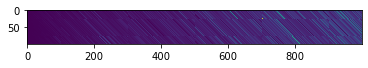

In [110]:

m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B



#Arbitrary c. (We don't know what it is)
#We're also not entirely sure about the d. We need to find more sources.
dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)
plt.imshow(dist_matrix[-100:,:])


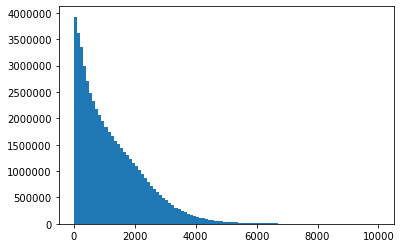

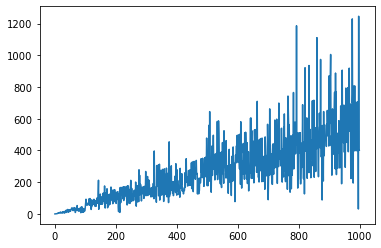

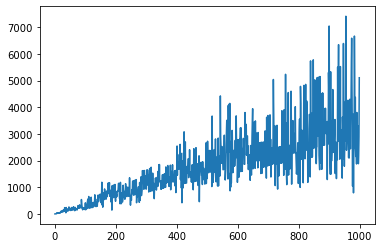

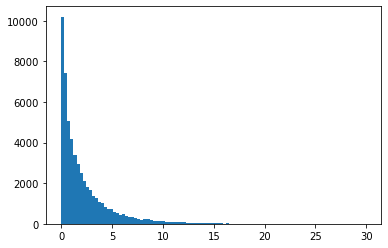

In [111]:

plt.hist(dist_matrix.flatten()[np.abs(dist_matrix.flatten())<1e4], bins =100)
plt.show() # Histogram of all values in the distance matrix


plt.plot(range(1000), dist_matrix[5000])
plt.show() #An example of the distance between one earthquake and 1000 previous
plt.plot(range(1000), dist_matrix[50000])
plt.show() #An example of the distance between one earthquake and 1000 previous

next_time=np.min(dist_matrix,axis=1) #Histogram of the distance between earthquakes and closest earthquake 
plt.hist(next_time[next_time <30], bins =100)
plt.show()

# Nearest Neighbour functions 

In [112]:
#Nearest neighbour pairs

def find_nearest_neighbours(sparse_matrix, threshold):
    nn=[] #To store edges in upcoming graph 
    for i in range(sparse_matrix.shape[0]):
        if np.min(dist_matrix[i,:])<threshold: # This threshold can be changed and was chosen arbitrarily 
            nn.append([i, int(-np.argmin(sparse_matrix[i,:])+i-1)])
    return nn

def find_nearest_neighbours_space_time(sparse_matrix, space_matrix, time_matrix, space_thresh, time_thresh):
    nn=[] #To store edges in upcoming graph 
    for i in range(sparse_matrix.shape[0]):
        minimum=np.argmin(dist_matrix[i,:])
        if np.min(time_matrix[i,minimum])<time_thresh: # This threshold can be changed and was chosen arbitrarily 
            if np.min(space_matrix[i,minimum])<space_thresh:
                nn.append([i, int(-np.argmin(sparse_matrix[i,:])+i-1)])
    return nn


nn=find_nearest_neighbours(dist_matrix, 3)

In [113]:
#Build the graph and find the connected components

def find_connected_components(nearest_neighbours, graph_size, save=False):
    G = nx.Graph()
    G.add_nodes_from(range(graph_size))
    G.add_edges_from(nearest_neighbours)
    clusters=list(nx.connected_components(G))
    clusters[:100]
    if save:
        import csv
        with open('Nearest_neightbour_earthquake_clusters_r0_3.csv', 'w') as f:

            # using csv.writer method from CSV package
            write = csv.writer(f)

            write.writerows(clusters)
    return clusters
clusters=find_connected_components(nn,sismos.shape[0])

In [114]:
#Find the centers
def find_cluster_centers(clusters, save=False, save_name='Test.npy'):
    centroids=[]
    for i in range(len(clusters)):
        centroids.append(np.array(list(clusters[i]))[np.argmax(m[np.array(list(clusters[i]))])])
    if save:
        np.save(save_name, centroids)
    return centroids              

    
centers=find_cluster_centers(clusters, save_name='Nearest_neightbour_earthquake_centres_r0_3.npy')

# Playing with different R0 values

$ \eta_{i,j}= n_{i,j} $ if $n_{i,j}<r_0$  with infity otherwise

In [115]:
#find the clusters for a range of r0 values
dist_matrixdist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)
for i in range(2,11):
    nn=find_nearest_neighbours(dist_matrix, i)
    clusters=find_connected_components(nn,sismos.shape[0])
    find_cluster_centers(clusters, save=True, save_name='Nearest_neightbour_earthquake_centres_r0_'+str(i).zfill(2)+'.npy')

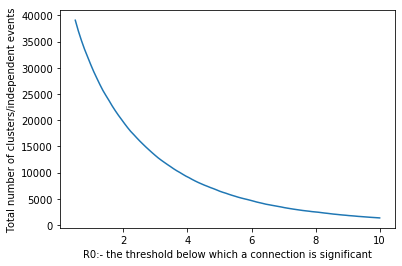

In [116]:
#Plot the number of clusters against the r0 value 
plot=np.zeros(100)
for i, r0 in enumerate(np.linspace(0.5,10, 100)):
    nn=find_nearest_neighbours(dist_matrix, r0)
    clusters=find_connected_components(nn,sismos.shape[0])
    plot[i]=len(clusters)
plt.plot(np.linspace(0.5,10, 100), plot)
plt.xlabel('R0:- the threshold below which a connection is significant')
plt.ylabel('Total number of clusters/independent events')
plt.show()

# Some visualisations of data

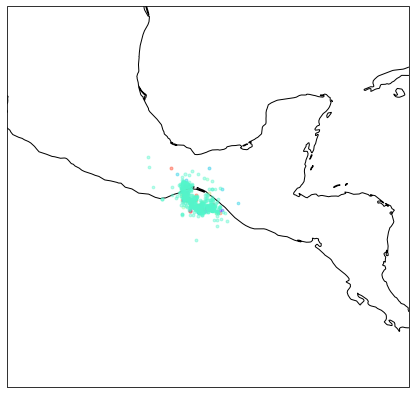

In [117]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#Plot a small section
#Set threshold value and find clusters
r0=3
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B
dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)

nn=find_nearest_neighbours(dist_matrix, r0)
clusters=find_connected_components(nn,sismos.shape[0])

#numpy arrays of the data
lats=sismos['Latitud'].to_numpy()
lons=sismos['Longitud'].to_numpy()
magnitudes= sismos['Magnitud'].to_numpy()



#Create a vector with a different numerical value for each cluster 
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())



# Plotting 2000 points and their clusters 
fig, ax = plt.subplots(figsize=(12,7))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=300)) # try centering the map somewhere else
ax.set_extent([lons.min()-8, lons.max()+8, lats.min()-8, lats.max()+8])

ax.add_feature(cfeature.COASTLINE)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lats=sismos['Latitud'].to_numpy()
lons=sismos['Longitud'].to_numpy()
magnitudes= sismos['Magnitud'].to_numpy()


count=0
min_marker_size = 2.25
for lon, lat, mag in zip(lons[3000:4000], lats[3000:4000], magnitudes[3000:4000]):
    msize = mag * min_marker_size
    ax.scatter(lon,lat,s=msize, zorder=10, color = plt.cm.rainbow(norm(colours[count])) ,alpha=0.4, transform=ccrs.PlateCarree())
    count+=1
plt.show()

C:\Users\marga\anaconda3\envs\odl-py37\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


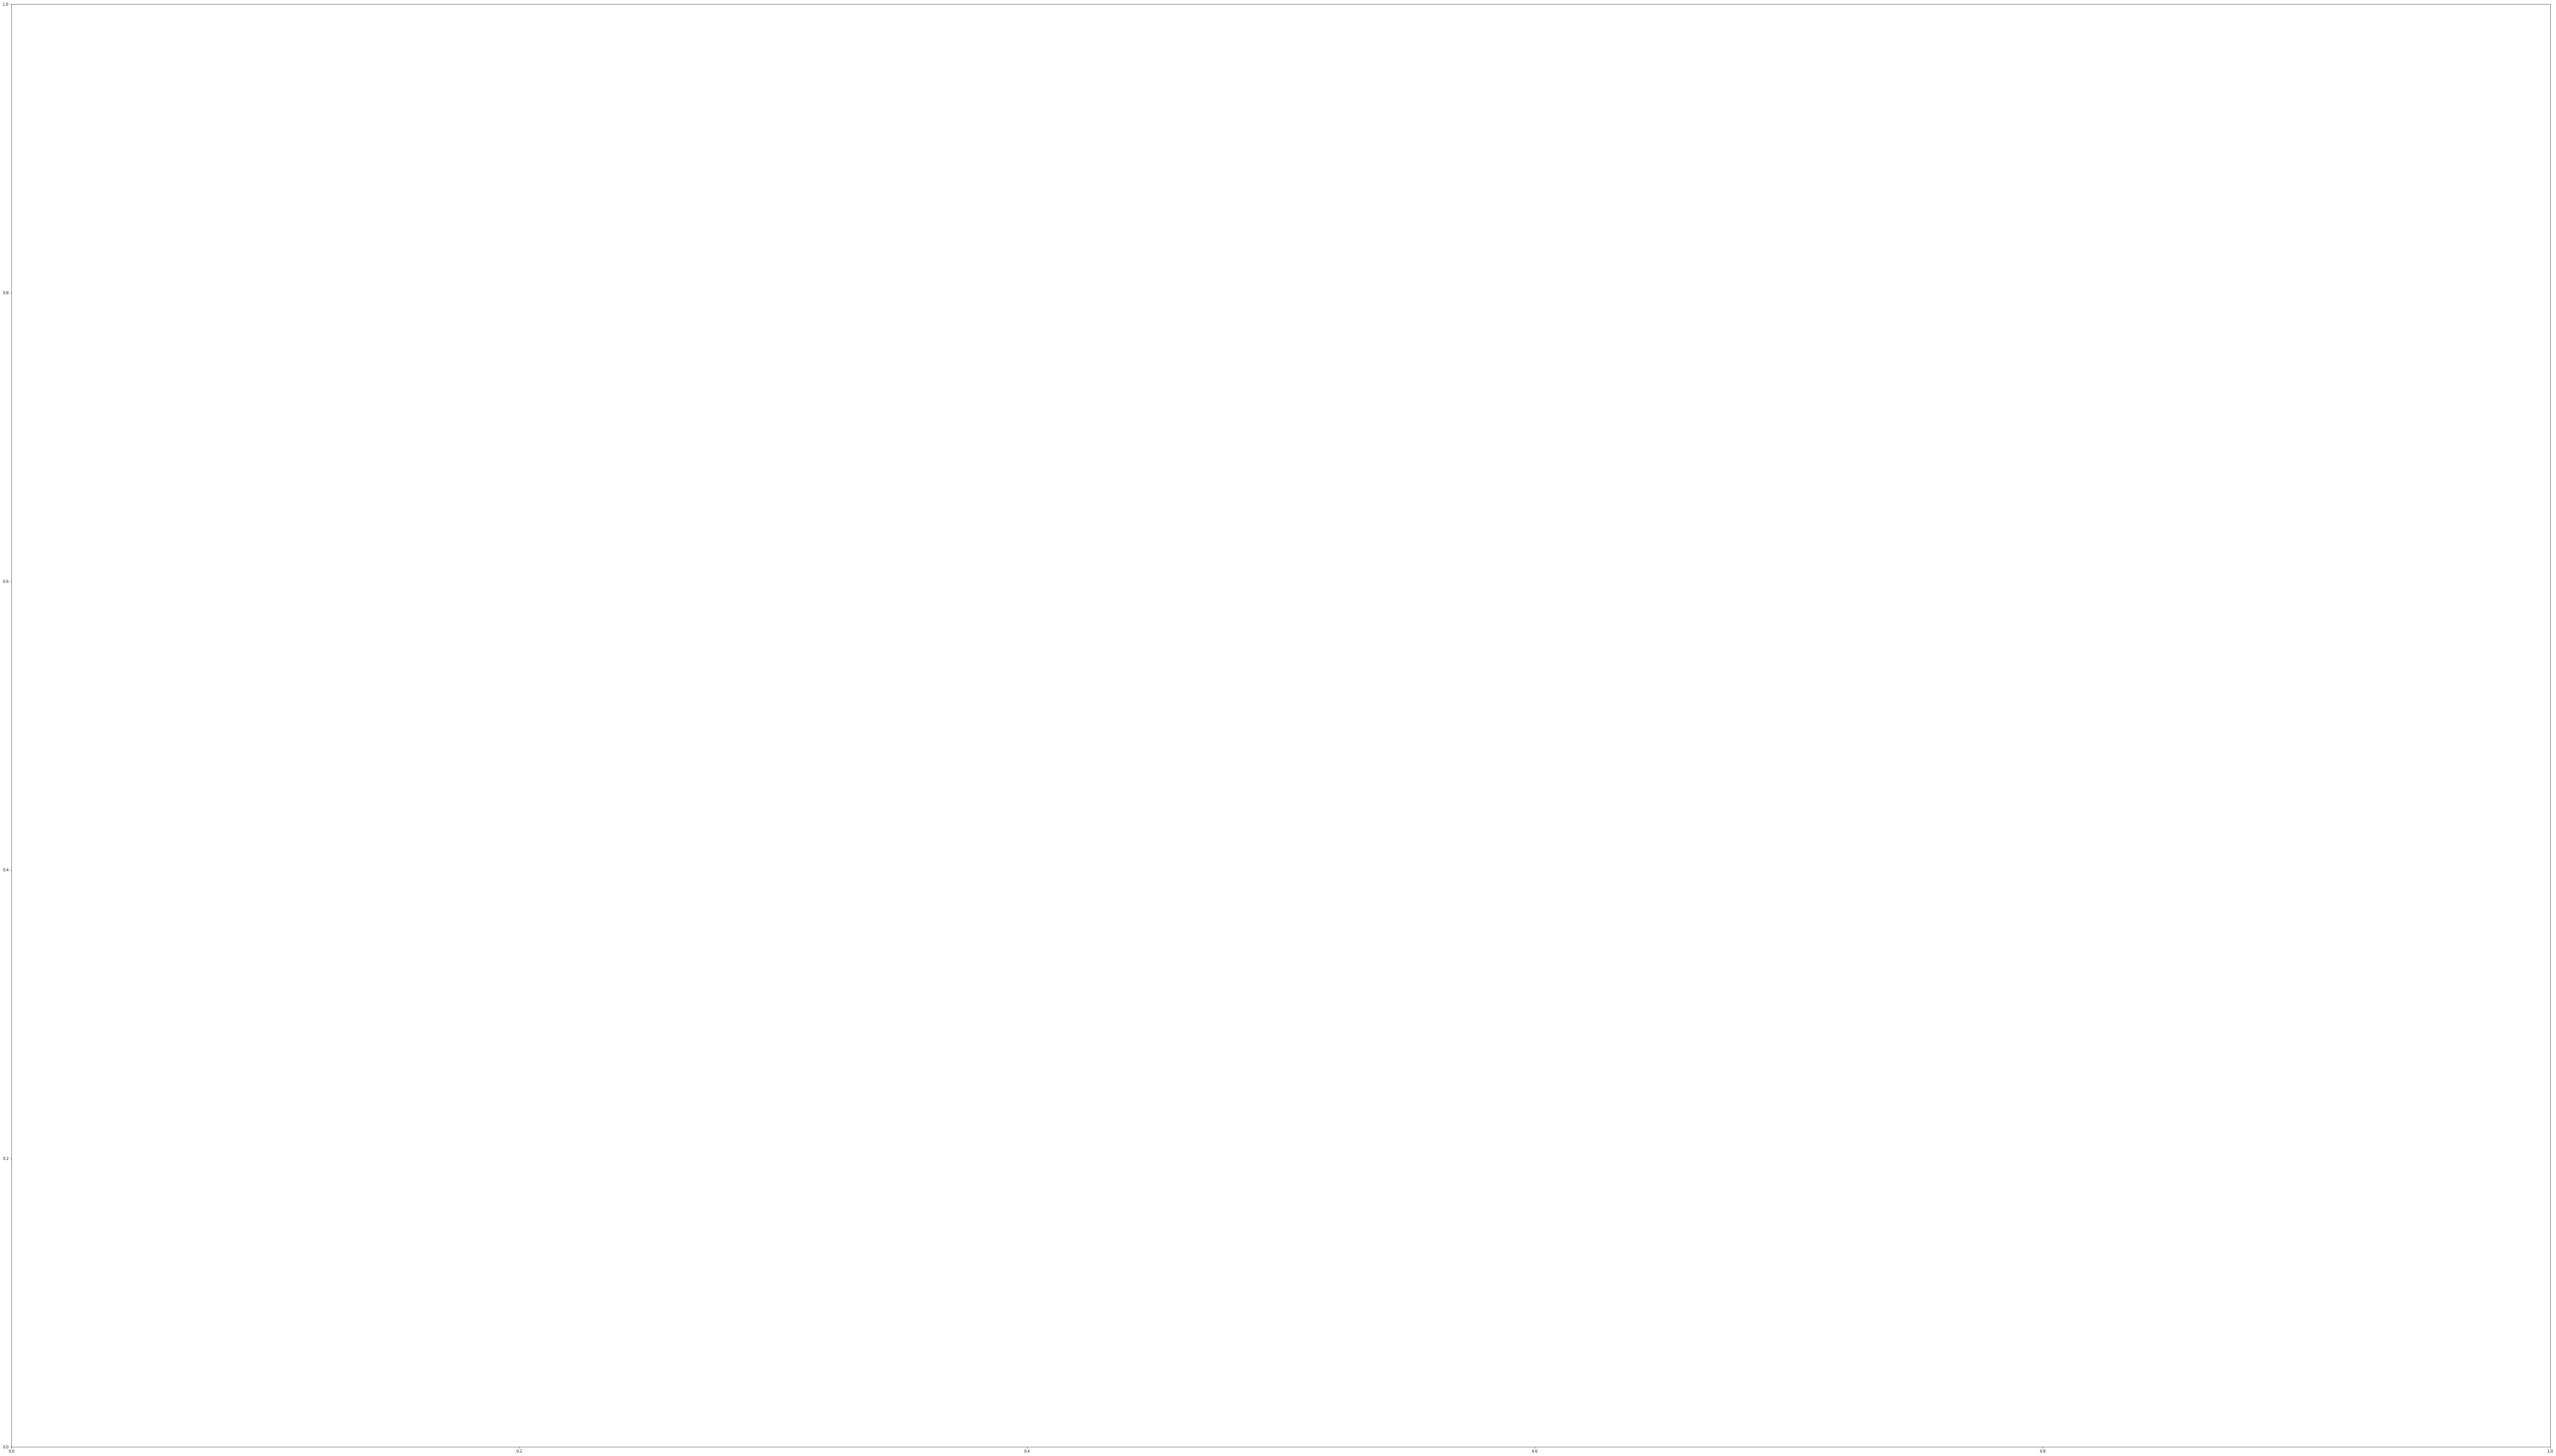

In [118]:
##Make Video
#Set threshold value and find clusters
r0=3
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B
dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)
nn=find_nearest_neighbours(dist_matrix, r0)
clusters=find_connected_components(nn,sismos.shape[0])

#Create a vector with a different numerical value for each cluster 
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())


#List of all the dates 
dates=sismos['Fecha'].values.tolist()
dates= list(dict.fromkeys(dates))

#Build figure
fig, ax = plt.subplots(figsize=(120,70))

#numpy arrays of the data
lats_all=sismos['Latitud'].to_numpy()
lons_all=sismos['Longitud'].to_numpy()
magnitudes= sismos['Magnitud'].to_numpy()

#Plotting
count=0
for i, date in enumerate(dates): 
    fig, ax = plt.subplots()
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=300)) # try centering the map somewhere else
    ax.set_extent([lons_all.min()-8, lons_all.max()+8, lats_all.min()-8, lats_all.max()+8])
    ax.add_feature(cfeature.OCEAN)
    #ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    date_info=sismos.loc[sismos['Fecha'] == date]
    lats=date_info['Latitud'].to_numpy()
    lons=date_info['Longitud'].to_numpy()
    magnitudes= date_info['Magnitud'].to_numpy()
    for lon, lat, mag in zip(lons, lats, magnitudes):
        msize = min_marker_size*mag
        ax.scatter(lon,lat,s=msize, zorder=10, color=plt.cm.rainbow(norm(colours[count])) ,transform=ccrs.PlateCarree())
        count+=1
    plt.savefig('Time_plot_'+str(i).zfill(5)+'.png')
    plt.close()
    
#making a video
import glob
import cv2
 
img_array = []
for filename in glob.glob('.//Time_plot*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
fourcc=cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('nn_cluster_video.mp4',fourcc, 15, size)
 
#deleting old files 
import os 
for i in range(len(img_array)):
    out.write(img_array[i])
for filename in glob.glob('.//Time_plot*.png'):
    os.remove(filename)
out.release()

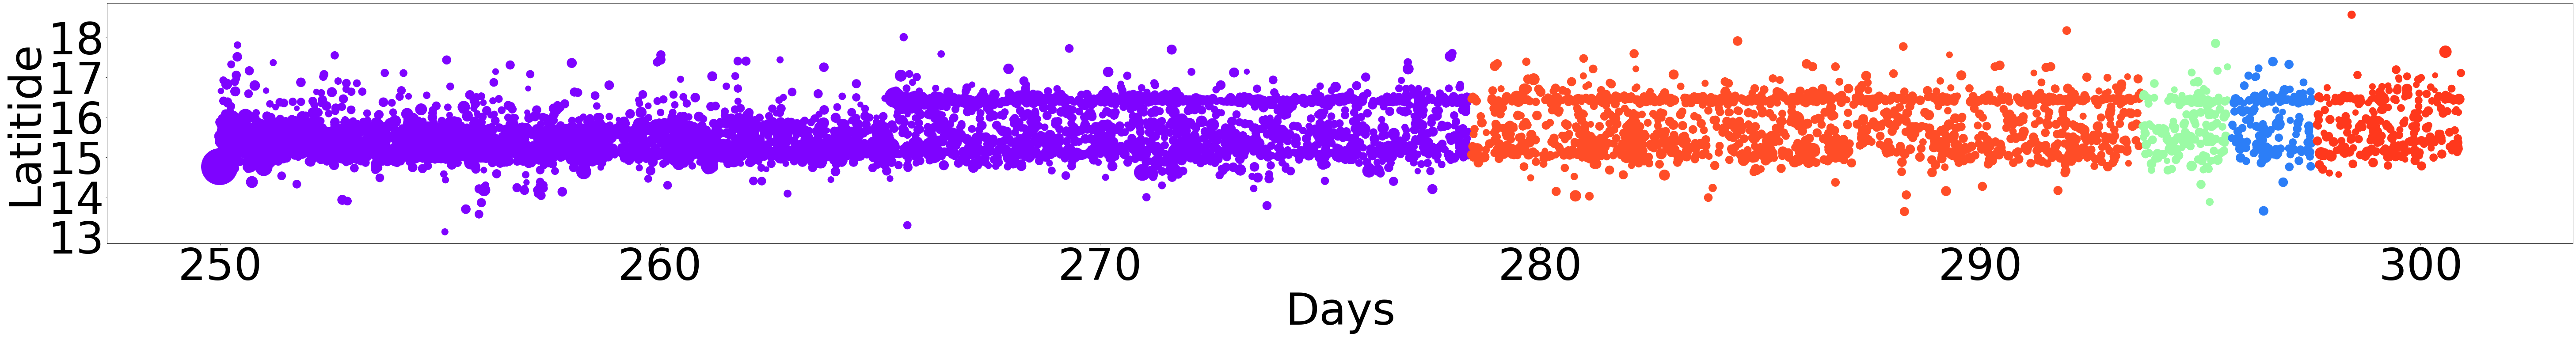

In [119]:
#Lattitude against time 
#Set threshold value and find clusters
r0=6
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B
dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d, 5000)
nn=find_nearest_neighbours(dist_matrix, r0)
clusters=find_connected_components(nn,sismos.shape[0])

#Create a vector with a different numerical value for each cluster
np.random.seed(99)
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())

lats_all=sismos['Latitud'].to_numpy()
time=((sismos["timestamp"] - pd.Timestamp("2017-01-01")) // pd.Timedelta('1s')).to_numpy()
time=time/(60*60*24)
magnitudes= sismos['Magnitud'].to_numpy()
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], lats_all[133:8000],s=1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.xlabel('Days', fontsize=100)
plt.ylabel('Latitide', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('Latitude_against_time_nn_cluster_r0_6.jpg')
plt.show()

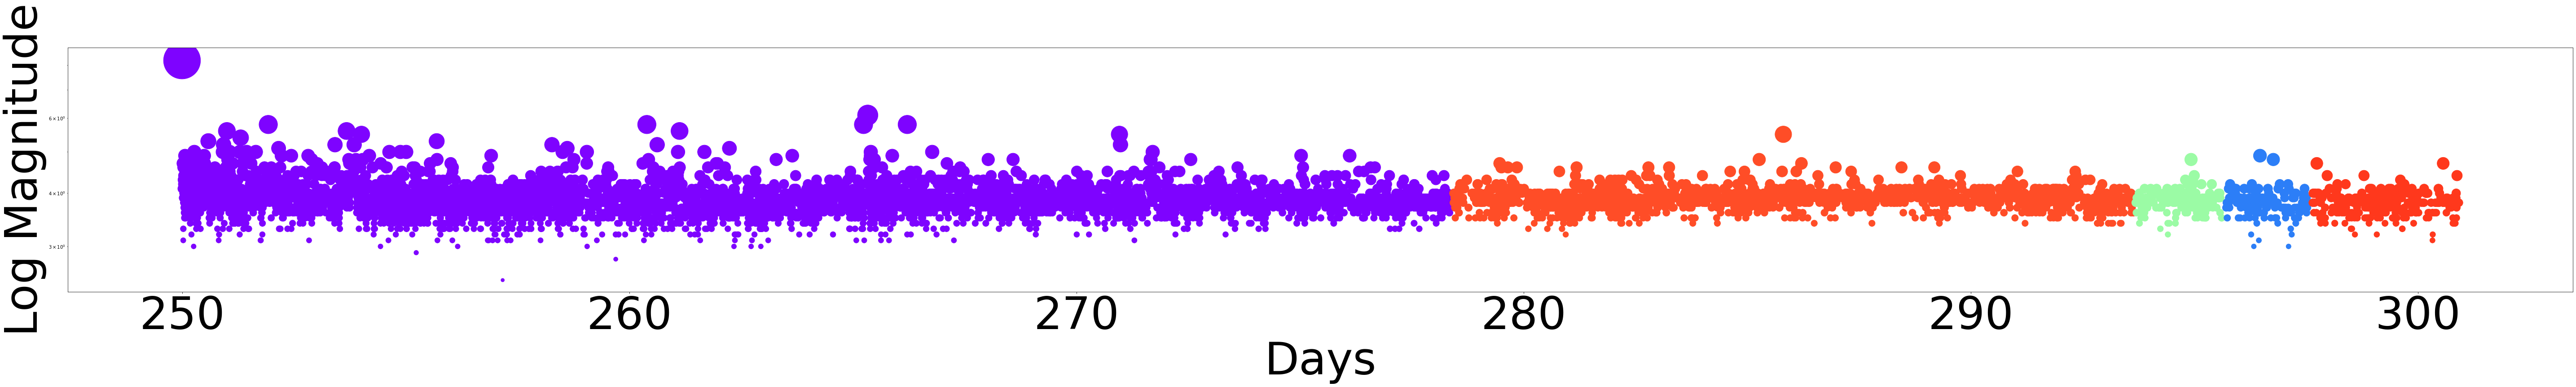

In [132]:
#Magnitude against time 
#Set threshold value and find clusters
r0=6
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B
dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d, 1000)

nn=find_nearest_neighbours(dist_matrix, r0)
clusters=find_connected_components(nn,sismos.shape[0])

#Create a vector with a different numerical value for each cluster 
np.random.seed(99)
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())

lats_all=sismos['Latitud'].to_numpy()
time=((sismos["timestamp"] - pd.Timestamp("2017-01-01")) // pd.Timedelta('1s')).to_numpy()
time=time/(60*60*24)
magnitudes= sismos['Magnitud'].to_numpy()
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], magnitudes[133:8000],1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.yscale('log')
plt.xlabel('Days', fontsize=100)
plt.ylabel('Log Magnitude', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)

plt.savefig('Log magnitude_against_time_nn_cluster_r0_'+str(r0)+'.jpg')
plt.show()

# Play with the b and d values 

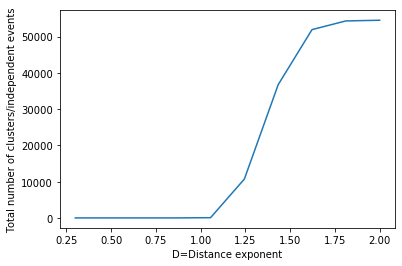

In [121]:
#Plot the number of clusters against the r0 value 
r0=4
plot=np.zeros(10)
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))


for i, d in enumerate(np.linspace(0.3,2, 10)):
    dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)
    nn=find_nearest_neighbours(dist_matrix, r0)
    clusters=find_connected_components(nn,sismos.shape[0])
    plot[i]=len(clusters)
plt.plot(np.linspace(0.3,2, 10), plot[:10])
plt.xlabel('D=Distance exponent')
plt.ylabel('Total number of clusters/independent events')
plt.show()

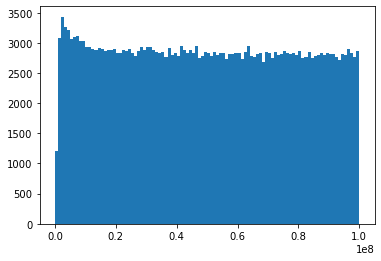

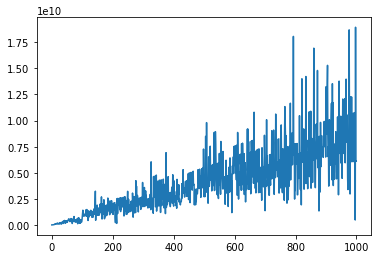

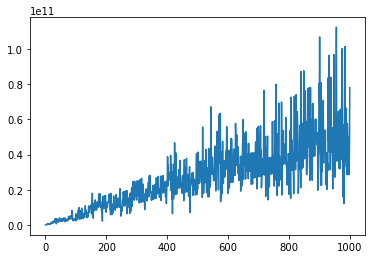

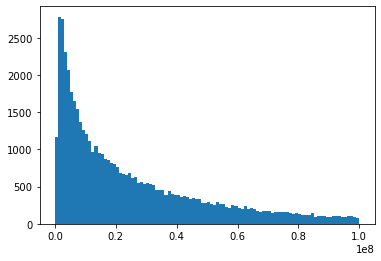

In [122]:
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
d=3

dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)

plt.hist(dist_matrix.flatten()[np.abs(dist_matrix.flatten())<1e8], bins =100)
plt.show() # Histogram of all values in the distance matrix


plt.plot(range(1000), dist_matrix[5000])
plt.show() #An example of the distance between one earthquake and 1000 previous
plt.plot(range(1000), dist_matrix[50000])
plt.show() #An example of the distance between one earthquake and 1000 previous

next_time=np.min(dist_matrix,axis=1) #Histogram of the distance between earthquakes and closest earthquake 
plt.hist(next_time[next_time <1e8], bins =100)
plt.show()

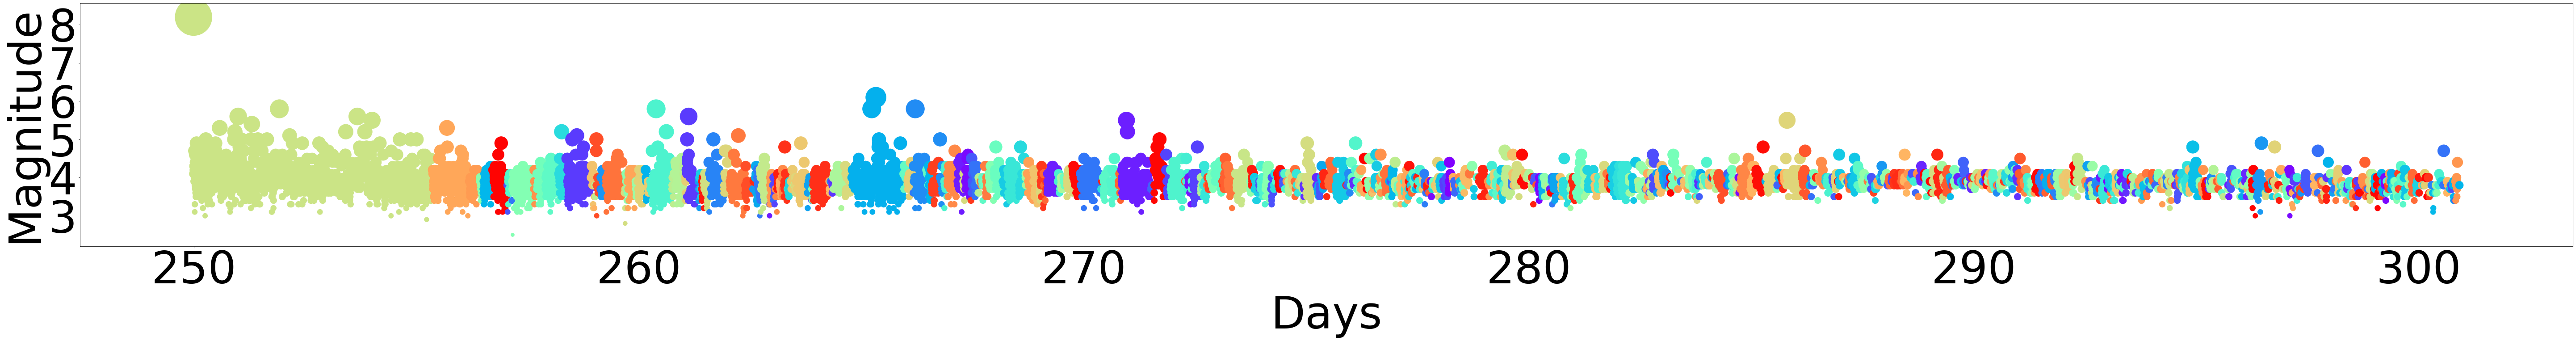

In [123]:
r0=0.2e8
d=3

dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)

nn=find_nearest_neighbours(dist_matrix, r0)
clusters=find_connected_components(nn,sismos.shape[0])

#Create a vector with a different numerical value for each cluster 
np.random.seed(99)
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())

lats_all=sismos['Latitud'].to_numpy()
time=((sismos["timestamp"] - pd.Timestamp("2017-01-01")) // pd.Timedelta('1s')).to_numpy()
time=time/(60*60*24)
magnitudes= sismos['Magnitud'].to_numpy()
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], magnitudes[133:8000],1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.yscale('log')
plt.xlabel('Days', fontsize=100)
plt.ylabel('Log magnitude', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('Log agnitude_against_time_nn_cluster_r0_'+str(r0)+'_d_'+str(d)+'_B_'+str(B)+'.jpg')
plt.show()

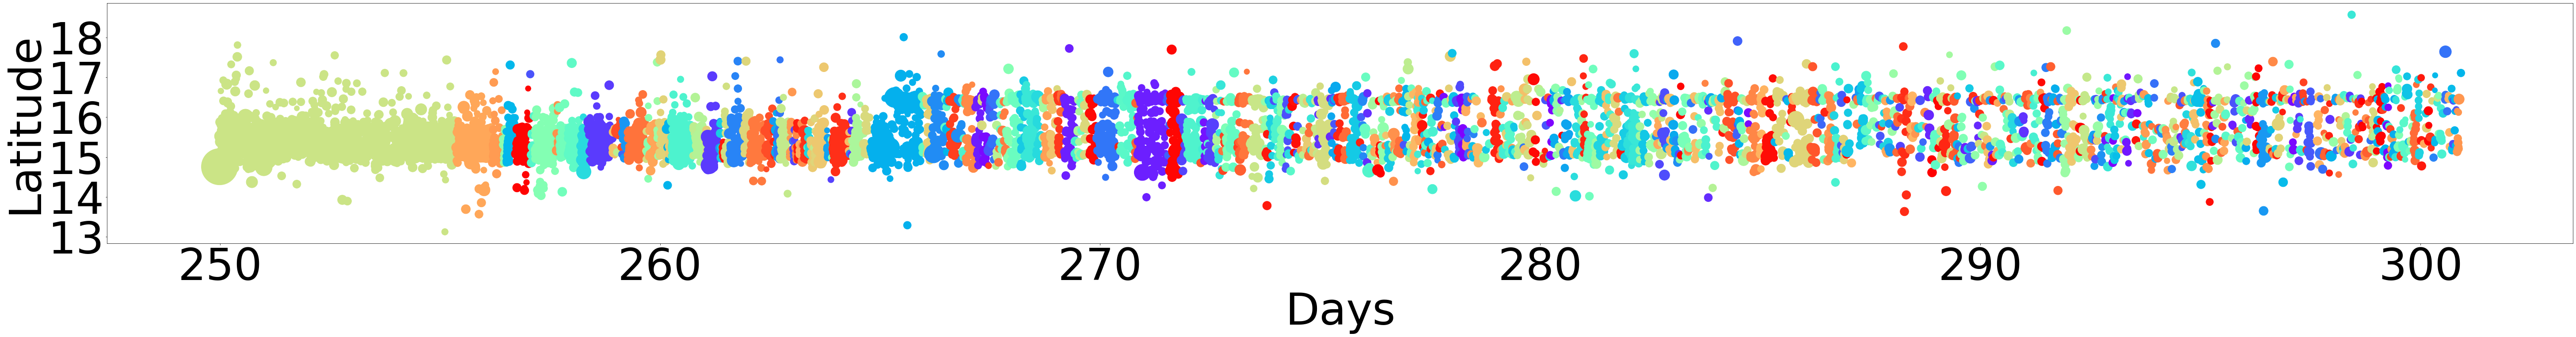

In [124]:
r0=0.2e8
d=3
dist_matrix,_,_=dist_quakes_sparse(sismos, B, 1, d)

nn=find_nearest_neighbours(dist_matrix, r0)
clusters=find_connected_components(nn,sismos.shape[0])

#Create a vector with a different numerical value for each cluster 
np.random.seed(99)
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())

lats_all=sismos['Latitud'].to_numpy()
time=((sismos["timestamp"] - pd.Timestamp("2017-01-01")) // pd.Timedelta('1s')).to_numpy()
time=time/(60*60*24)
magnitudes= sismos['Magnitud'].to_numpy()
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], lats_all[133:8000],1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.xlabel('Days', fontsize=100)
plt.ylabel('Latitude', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('Latititude_against_time_nn_cluster_r0_'+str(r0)+'_d_'+str(d)+'_B_'+str(B)+'.jpg')
plt.show()

# Changing the threshold criteria

$ \eta_{i,j}= n_{i,j} $ if $t_{i,j}<t_0$ and $r_{i,j}<d0$ with infity otherwise

In [125]:
#Magnitude against time 
#Set threshold value and find clusters
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B
dist_matrix,space_matrix,time_matrix=dist_quakes_sparse(sismos, B, 1, d)

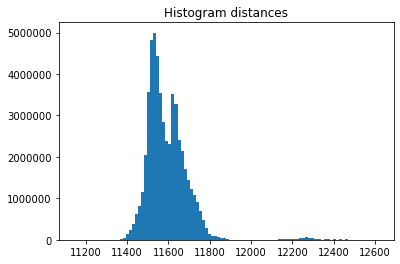

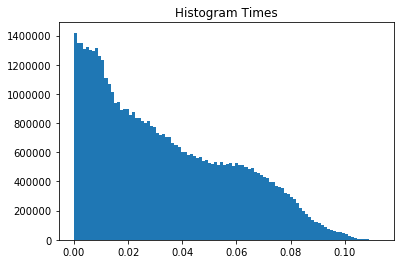

In [126]:

plt.hist(space_matrix.flatten()[np.abs(space_matrix.flatten())<1e8], bins =100)
plt.title('Histogram distances')
plt.show() # Histogram of all values in the distance matrix


plt.hist(time_matrix.flatten()[np.abs(time_matrix.flatten())<3], bins =100)
plt.title('Histogram Times')
plt.show() # Histogram of all values in the distance matrix



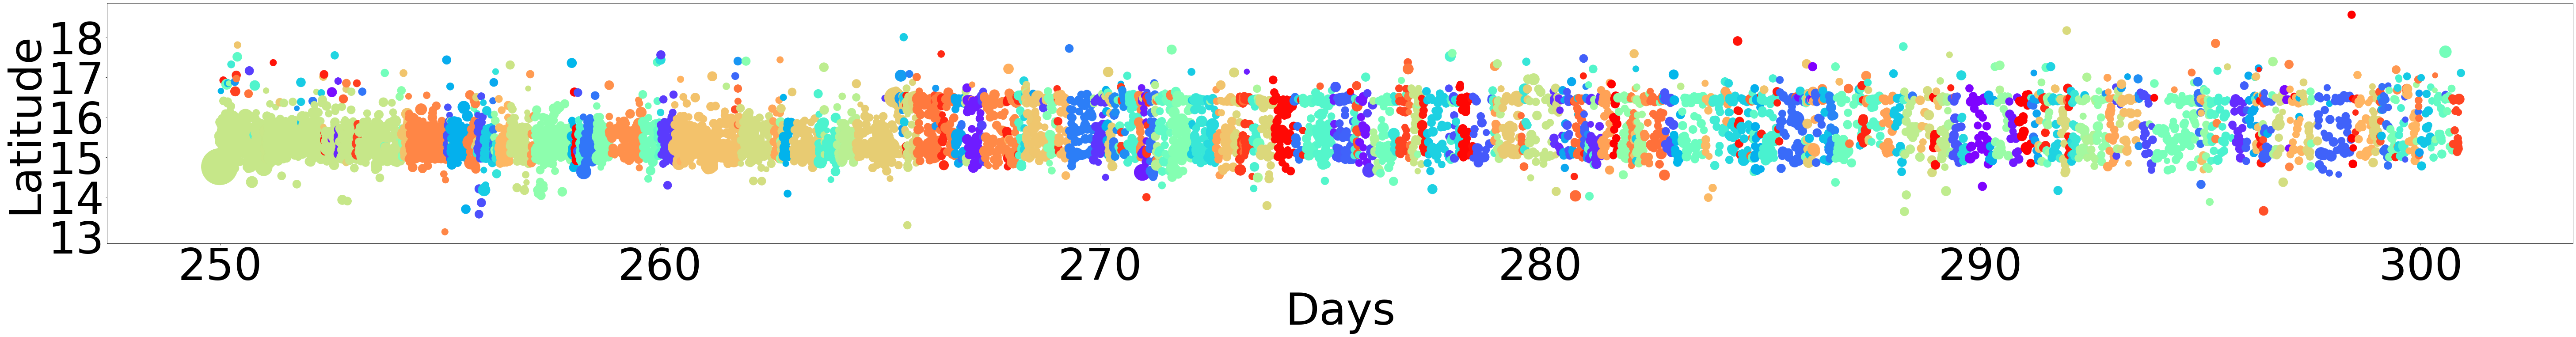

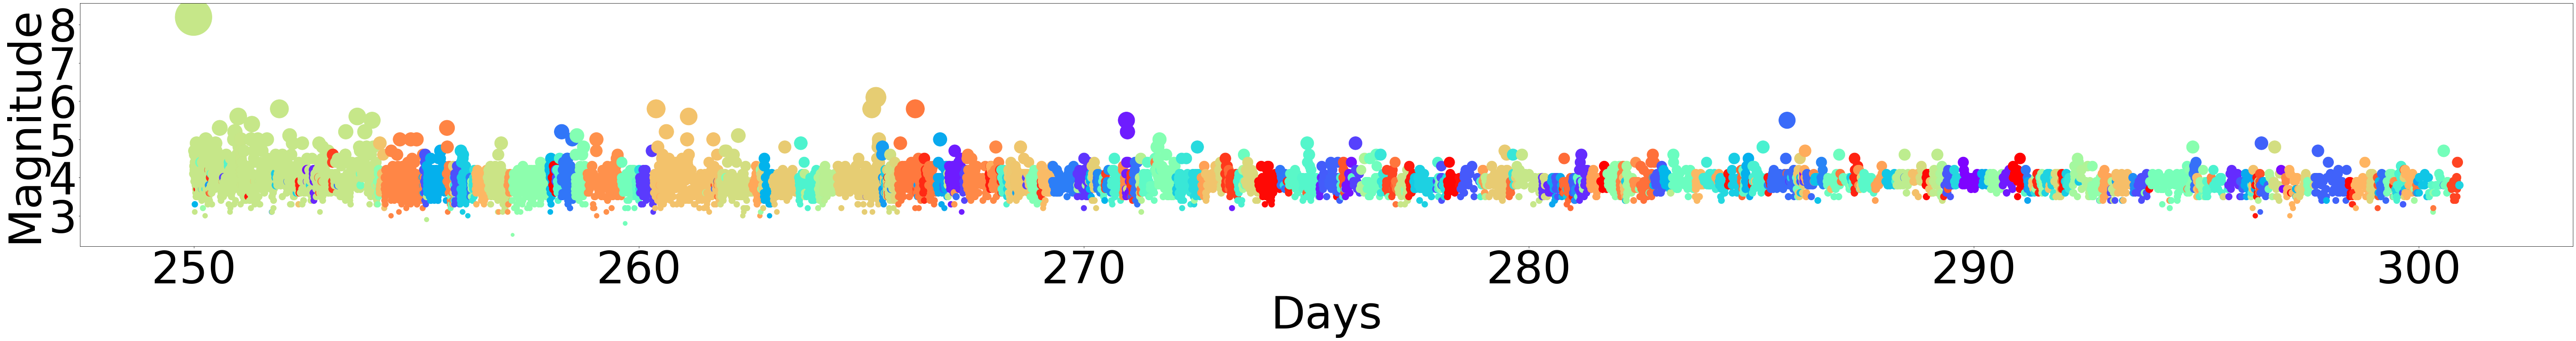

In [127]:
d0=11650
t0= 0.1
nn=find_nearest_neighbours_space_time(dist_matrix, space_matrix, time_matrix, d0, t0)
clusters=find_connected_components(nn,sismos.shape[0])
                                   
#Create a vector with a different numerical value for each cluster 
np.random.seed(99)
cluster_colours=np.random.rand(len(clusters))
colours=np.zeros(sismos.shape[0])
for i in range(len(clusters)):
    colours[np.array(list(clusters[i]))]=cluster_colours[i]
norm = colors.Normalize(vmin=colours.min(), vmax=colours.max())

lats_all=sismos['Latitud'].to_numpy()
time=((sismos["timestamp"] - pd.Timestamp("2017-01-01")) // pd.Timedelta('1s')).to_numpy()
time=time/(60*60*24)
magnitudes= sismos['Magnitud'].to_numpy()
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], lats_all[133:8000],1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.xlabel('Days', fontsize=100)
plt.ylabel('Latitude', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('Latititude_against_time_nn_cluster_d0_'+str(d0)+'_t0_'+str(t0)+'_d_'+str(d)+'_B_'+str(B)+'.jpg')
plt.show()
    
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], magnitudes[133:8000],1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.yscale('log')
plt.xlabel('Days', fontsize=100)
plt.ylabel('Log magnitude', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('Log magnitude_against_time_nn_cluster_d0_'+str(d0)+'_t0_'+str(t0)+'_d_'+str(d)+'_B_'+str(B)+'.jpg')
plt.show()
                                 

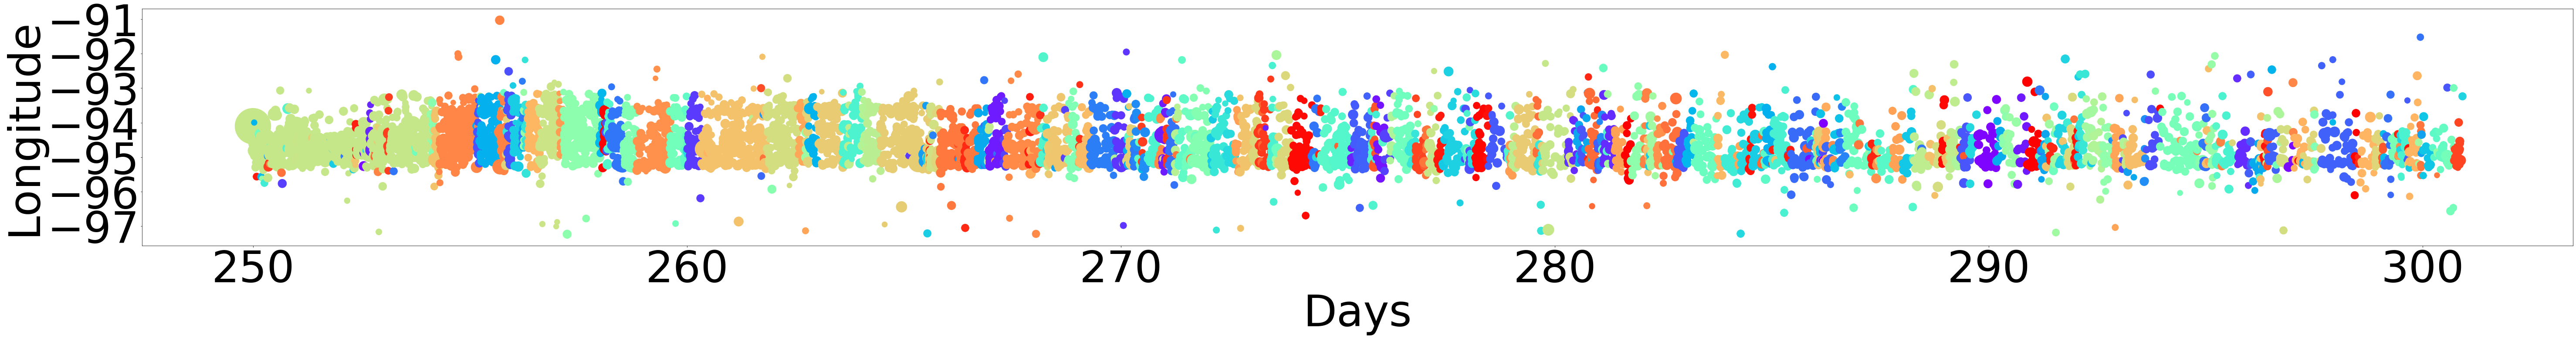

In [128]:
long_all=sismos['Longitud'].to_numpy()
time=((sismos["timestamp"] - pd.Timestamp("2017-01-01")) // pd.Timedelta('1s')).to_numpy()
time=time/(60*60*24)
magnitudes= sismos['Magnitud'].to_numpy()
plt.figure(figsize=(100,10))
plt.scatter(time[133:8000], long_all[133:8000],1.5*magnitudes[133:8000]**4, c=plt.cm.rainbow(norm(colours)[133:8000]))
plt.xlabel('Days', fontsize=100)
plt.ylabel('Longitude', fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('Longitude_against_time_nn_cluster_d0_'+str(d0)+'_t0_'+str(t0)+'_d_'+str(d)+'_B_'+str(B)+'.jpg')
plt.show()